In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from copy import deepcopy
from itertools import product
from pprint import pprint
from itertools import islice, combinations

import alphashape
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import seaborn as sns
import shapely
from matplotlib import cm, colors
from shapely.ops import cascaded_union
from tqdm import tqdm
from util import *

In [3]:
ox.config(use_cache=True)

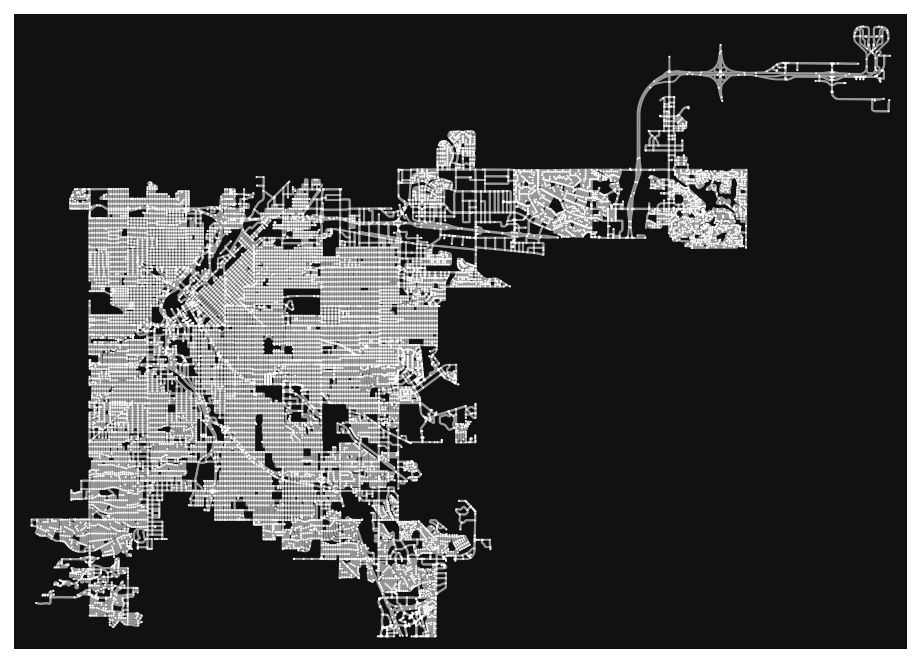

In [4]:
G = ox.graph_from_place("Denver, Colorado, USA", network_type="drive")
fig, ax = ox.plot_graph(G, node_size=1)

In [5]:
G = ox.speed.add_edge_speeds(
    G,
    hwy_speeds={
        "residential": 40.23,
    },
)

In [6]:
neighborhoods = gpd.read_file(
    "../data/statistical_neighborhoods.gdb", driver="OpenFileGDB"
)

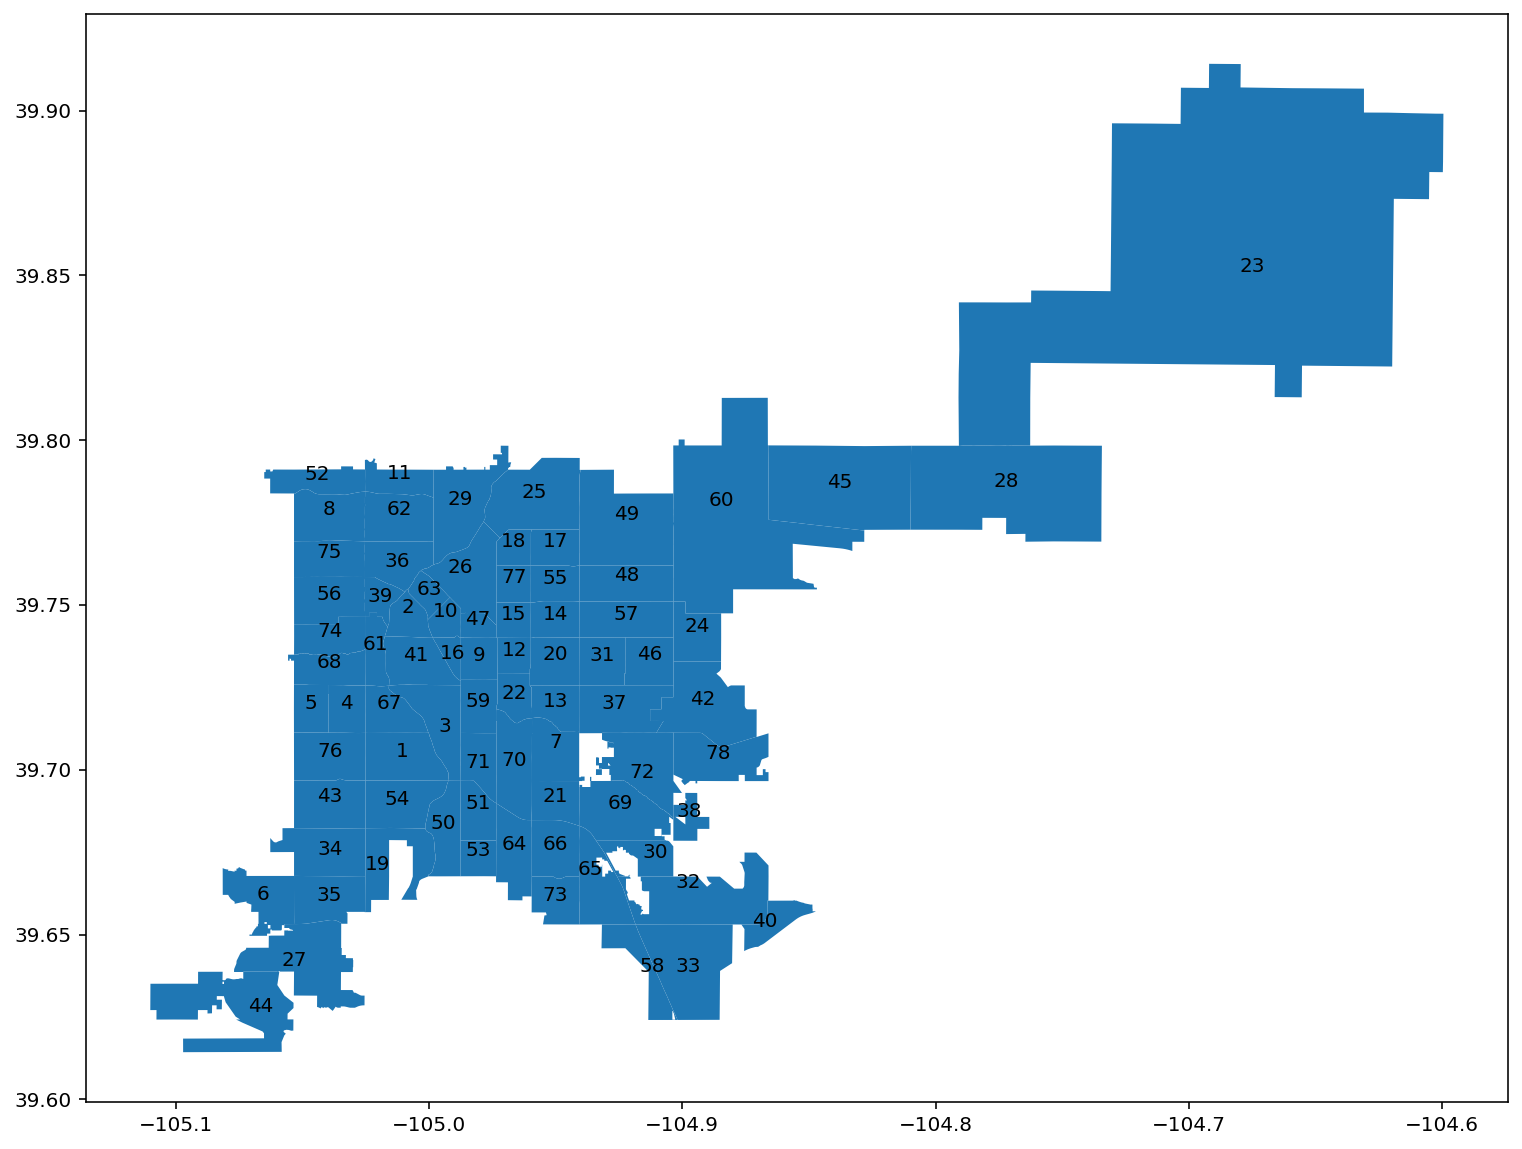

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
neighborhoods.plot(ax=ax, legend=True)
for idx, row in neighborhoods.iterrows():
    plt.annotate(
        text=row["NBHD_ID"],
        xy=row["geometry"].representative_point().coords[0],
        horizontalalignment="center",
    )

In [8]:
neighborhoods[neighborhoods["NBHD_ID"] == 10]

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,SHAPE_Length,SHAPE_Area,geometry
48,10,CBD,None,None,0.042534,0.000117,"MULTIPOLYGON (((-104.98740 39.74736, -104.9874..."


In [9]:
DOWNTOWN_IDS = [63, 10, 26, 47]
SOUTH_CENTRAL = [9, 59, 12, 22, 20, 13]
OVERLAND = [50]

In [10]:
neighborhoods_of_interest = neighborhoods[neighborhoods["NBHD_ID"].isin(OVERLAND)]
neighborhoods_of_interest

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,SHAPE_Length,SHAPE_Area,geometry
33,50,Overland,None,None,0.082263,0.000305,"MULTIPOLYGON (((-104.98743 39.69663, -104.9874..."


In [11]:
neighborhoods_of_interest_poly = cascaded_union(
    neighborhoods_of_interest.geometry.values
)
map_a = ox.graph.graph_from_polygon(
    neighborhoods_of_interest_poly, network_type="drive"
)

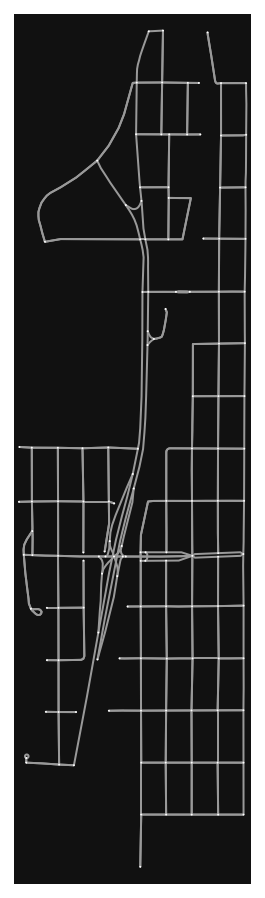

In [12]:
fig, ax = ox.plot_graph(map_a, node_size=1)

In [13]:
boundary_nodes = set()
for node in map_a.nodes:
    if map_a.degree(node) != G.degree(node):
        boundary_nodes.add(node)

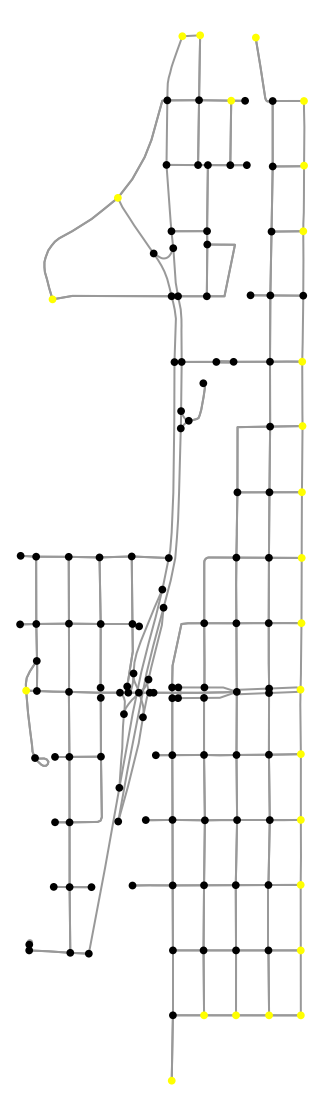

In [14]:
nc_terminal = ["yellow" if n in boundary_nodes else "k" for n in map_a.nodes]

fig, ax = ox.plot_graph(
    map_a,
    node_alpha=1,
    node_color=nc_terminal,
    show=False,
    bgcolor="white",
    figsize=(10, 10),
)

In [15]:
map_a = ox.speed.add_edge_speeds(
    map_a,
    hwy_speeds={
        "residential": 40.23,
    },
)

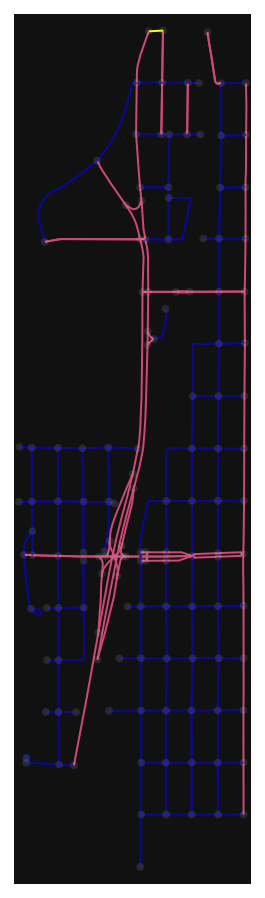

In [16]:
ec = ox.plot.get_edge_colors_by_attr(map_a, "speed_kph", cmap="plasma")
fig, ax = ox.plot_graph(map_a, node_alpha=0.1, edge_color=ec)

In [17]:
map_a = drive_network_to_capacitated_network(map_a)

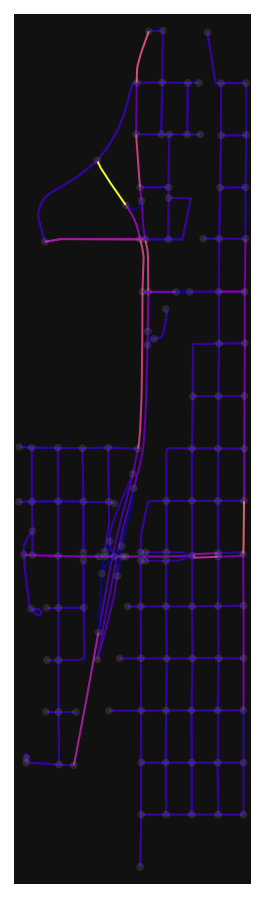

In [18]:
ec = ox.plot.get_edge_colors_by_attr(map_a, "capacity", cmap="plasma")
fig, ax = ox.plot_graph(map_a, node_alpha=0.1, edge_color=ec)

In [19]:
impacts = all_arc_removal_impact(nx.DiGraph(map_a), boundary_nodes)

All pairs Max Flow: 19it [00:02,  9.12it/s]                                                             
Removing arcs and determining impact: 100%|███████████████████████████| 346/346 [00:28<00:00, 12.24it/s]


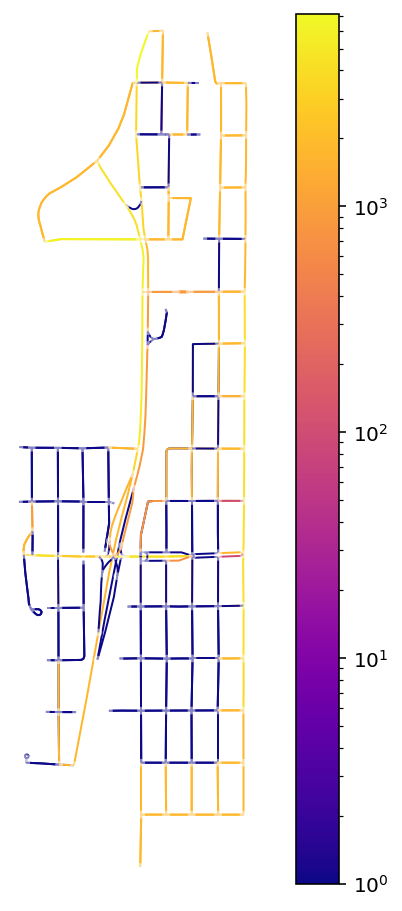

In [20]:
arc_max_impact = [max(impacts[(u, v)]) + 1 for (u, v) in map_a.edges()]

norm = colors.LogNorm()
norm.autoscale(arc_max_impact)
ec_max_impact = [cm.plasma(norm(f)) for f in arc_max_impact]

fig, ax = ox.plot_graph(
    map_a,
    node_alpha=0.5,
    edge_color=ec_max_impact,
    show=False,
    bgcolor="white",
)

cb = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cm.plasma), ax=ax, orientation="vertical"
)